# 1. Setup

## 1.2 Import Dependencies

In [6]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [1]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [7]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [9]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [10]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [8]:
#The below code is just changing the path of the file to the new path
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [13]:
#os.listdir('lfw')

## 2.2 Collect Positive and Anchor Classes

In [8]:
# Import uuid library to generate unique image names
import uuid

In [9]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/ead8ff92-08c1-11ed-8430-c212df7affb2.jpg'

In [10]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[200:200+250,500:500+250, :]
    
    # Collect anchors a
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [25]:
#import cv2
#cv2.namedWindow("preview")
#vc = cv2.VideoCapture(0)

#rval, frame = vc.read()

#while True:

  #if frame is not None:
     #cv2.imshow("preview", frame)
  #rval, frame = vc.read()

  #if cv2.waitKey(1) & 0xFF == ord('q'):
     #break

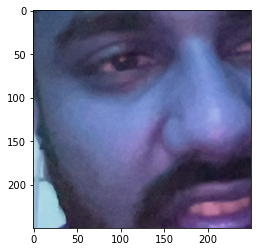

In [11]:
plt.imshow(frame)

# 2.x NEW - Data Augmentation

In [12]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [13]:
import os
import uuid

In [14]:
img_path = os.path.join(ANC_PATH, '0bb58b36-05f2-11ed-b8ec-c212df7affb2.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

2022-07-21 02:54:39.955532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
ANC_PATH+'/*.jpg'

'data/anchor/*.jpg'

In [16]:
img_path

'data/anchor/0bb58b36-05f2-11ed-b8ec-c212df7affb2.jpg'

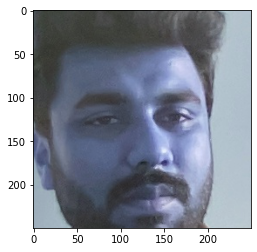

In [17]:
plt.imshow(augmented_images[0])

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [18]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(400)

In [19]:
dir_test = anchor.as_numpy_iterator()

In [20]:
print(dir_test.next())

b'data/anchor/c3510d6a-05f2-11ed-b8ec-c212df7affb2.jpg'


## 3.2 Preprocessing - Scale and Resize

In [21]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [22]:
img = preprocess('data/anchor/efadb2a2-05fa-11ed-b8ec-c212df7affb2.jpg')

In [23]:
img.numpy().max() 

0.9463235

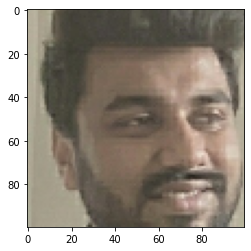

In [24]:
plt.imshow(img)

In [24]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

## 3.3 Create Labelled Dataset

In [20]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [25]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [26]:
samples = data.as_numpy_iterator()

In [27]:
exampple = samples.next()

In [28]:
exampple

(b'data/anchor/9f526ac6-0601-11ed-b8ec-c212df7affb2.jpg',
 b'data/positive/f36e55e8-05f7-11ed-b8ec-c212df7affb2.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [29]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [30]:
res = preprocess_twin(*exampple)

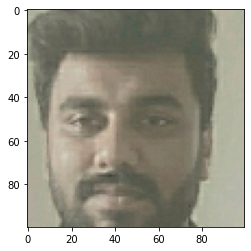

In [31]:
plt.imshow(res[1])

In [32]:
res[2]

1.0

In [33]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [34]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [35]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [36]:
inp = Input(shape=(100,100,3), name='input_image')

In [37]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [38]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [39]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [40]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [41]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [42]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [43]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [44]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [45]:
embedding = make_embedding()

In [46]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [47]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [48]:
l1 = L1Dist()

In [49]:
l1

In [51]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

## 4.3 Make Siamese Model

In [50]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [51]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [52]:
siamese_layer = L1Dist()

In [53]:
distances = siamese_layer(inp_embedding, val_embedding)

In [54]:
classifier = Dense(1, activation='sigmoid')(distances)

In [55]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [56]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [57]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [58]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [59]:
siamese_model = make_siamese_model()

In [60]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [61]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [62]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [63]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [64]:
test_batch = train_data.as_numpy_iterator()

In [65]:
batch_1 = test_batch.next()

In [66]:
X = batch_1[:2]

In [67]:
y = batch_1[2]

In [68]:
y

array([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.],
      dtype=float32)

In [69]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export('keras.losses.BinaryCrossentropy')
class BinaryCrossentropy(LossFunctionWrapper):
  """Computes the cross-entropy loss between true labels and predicted labels.

  Use this cross-entropy loss for binary (0 or 1) classification applications.
  The loss function requires the following inputs:

  - `y_true` (true label): This is either 0 or 1.
  - `y_pred` (predicted value): This is the model's prediction, i.e, a single
    floating-point value which either represents a
    [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
    when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
    `from_logits=False`).

  **Recommended Usage:** (set `from_logits=True`)

  With `tf.keras` API:

  ```python
  model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_log

In [70]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [71]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [72]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [73]:
EPOCHS = 5

In [74]:
train(train_data, EPOCHS)


 Epoch 1/5
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
35/35 [==============================] - 409s 12s/step
0.1951085 0.8802817 0.96899223

 Epoch 2/5
35/35 [==============================] - 416s 12s/step
0.1172308 0.953405 0.9888476

 Epoch 3/5
35/35 [==============================] - 419s 12s/step
0.0014262034 0.9814815 0.9962406

 Epoch 4/5
35/35 [==============================] - 439s 13s/step
0.13069773 0.985348 1.0

 Epoch 5/5
35/35 [==============================] - 456s 13s/step
0.02874838 0.9826389 0.99647886


# 6. Evaluate Model

## 6.1 Import Metrics

In [75]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [76]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [77]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


In [78]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]

In [79]:
y_true

array([0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [80]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [81]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [82]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 3s 3s/step
0.99130434 0.99130434


## 6.4 Viz Results

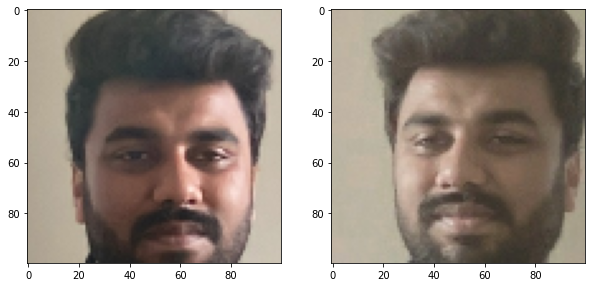

In [83]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [85]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [86]:
L1Dist

__main__.L1Dist

In [87]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [88]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[9.99832809e-01],
       [9.99985397e-01],
       [3.56976173e-08],
       [2.55737559e-05],
       [9.99935627e-01],
       [9.53139663e-01],
       [5.46125847e-08],
       [2.35393713e-03],
       [9.99984741e-01],
       [9.99920309e-01],
       [9.99984920e-01],
       [1.73237794e-07],
       [1.17952826e-04],
       [5.40365903e-08],
       [9.99232769e-01],
       [2.21364502e-07]], dtype=float32)

In [89]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

## 8.1 Verification Function

In [95]:
application_data/verification_images

NameError: name 'application_data' is not defined

In [96]:
os.listdir(os.path.join('application_data', 'verification_images'))

['12a52874-05f3-11ed-b8ec-c212df7affb2.jpg',
 '095ece28-05f3-11ed-b8ec-c212df7affb2.jpg',
 '16c177a0-05f3-11ed-b8ec-c212df7affb2.jpg',
 '84f32ee0-05f7-11ed-b8ec-c212df7affb2.jpg',
 '84f47e9e-05f7-11ed-b8ec-c212df7affb2.jpg',
 '168e7e5e-05f3-11ed-b8ec-c212df7affb2.jpg',
 '84f3db6a-05f7-11ed-b8ec-c212df7affb2.jpg',
 'e824b81c-05f2-11ed-b8ec-c212df7affb2.jpg',
 '0991caa8-05f3-11ed-b8ec-c212df7affb2.jpg',
 '84f3891c-05f7-11ed-b8ec-c212df7affb2.jpg',
 '1de7b2ba-05f3-11ed-b8ec-c212df7affb2.jpg',
 '178cfa7e-05f3-11ed-b8ec-c212df7affb2.jpg',
 '127238ba-05f3-11ed-b8ec-c212df7affb2.jpg',
 '1e1acc4a-05f3-11ed-b8ec-c212df7affb2.jpg',
 '1d81e6e2-05f3-11ed-b8ec-c212df7affb2.jpg',
 '17bfa938-05f3-11ed-b8ec-c212df7affb2.jpg',
 '85c7b912-05f7-11ed-b8ec-c212df7affb2.jpg',
 '16f46246-05f3-11ed-b8ec-c212df7affb2.jpg',
 '08c60dbe-05f3-11ed-b8ec-c212df7affb2.jpg',
 'e7d8a67a-05f2-11ed-b8ec-c212df7affb2.jpg',
 '0af5a7f2-05f3-11ed-b8ec-c212df7affb2.jpg',
 '85c23d6a-05f8-11ed-b8ec-c212df7affb2.jpg',
 '1726f68e

In [114]:
x=os.path.join('application_data', 'input_image', 'input_image.jpg')

In [115]:
x

'application_data/input_image/input_image.jpg'

In [98]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/12a52874-05f3-11ed-b8ec-c212df7affb2.jpg
application_data/verification_images/095ece28-05f3-11ed-b8ec-c212df7affb2.jpg
application_data/verification_images/16c177a0-05f3-11ed-b8ec-c212df7affb2.jpg
application_data/verification_images/84f32ee0-05f7-11ed-b8ec-c212df7affb2.jpg
application_data/verification_images/84f47e9e-05f7-11ed-b8ec-c212df7affb2.jpg
application_data/verification_images/168e7e5e-05f3-11ed-b8ec-c212df7affb2.jpg
application_data/verification_images/84f3db6a-05f7-11ed-b8ec-c212df7affb2.jpg
application_data/verification_images/e824b81c-05f2-11ed-b8ec-c212df7affb2.jpg
application_data/verification_images/0991caa8-05f3-11ed-b8ec-c212df7affb2.jpg
application_data/verification_images/84f3891c-05f7-11ed-b8ec-c212df7affb2.jpg
application_data/verification_images/1de7b2ba-05f3-11ed-b8ec-c212df7affb2.jpg
application_data/verification_images/178cfa7e-05f3-11ed-b8ec-c212df7affb2.jpg
application_data/verification_images/127238ba-05f3-11ed-b8ec-c21

In [110]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [140]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[300:300+250,300:300+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        
        #Save input image to application_data/input_image folder 
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)

        lim = 255 - 10
        v[v > lim] = 255
        v[v <= lim] -= 10
        
        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
      
        cv2.imwrite(os.path.join('application_data', 'input_imagee', 'input_image.png'), frame)
       
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

2022-07-21 12:46:42.499553: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: application_data/input_image/input_image.jpg; No such file or directory


NotFoundError: application_data/input_image/input_image.jpg; No such file or directory [Op:ReadFile]

In [135]:
cv2.imwrite??

Docstring:
imwrite(filename, img[, params]) -> retval
.   @brief Saves an image to a specified file.
.   
.   The function imwrite saves the image to the specified file. The image format is chosen based on the
.   filename extension (see cv::imread for the list of extensions). In general, only 8-bit
.   single-channel or 3-channel (with 'BGR' channel order) images
.   can be saved using this function, with these exceptions:
.   
.   - 16-bit unsigned (CV_16U) images can be saved in the case of PNG, JPEG 2000, and TIFF formats
.   - 32-bit float (CV_32F) images can be saved in PFM, TIFF, OpenEXR, and Radiance HDR formats;
.     3-channel (CV_32FC3) TIFF images will be saved using the LogLuv high dynamic range encoding
.     (4 bytes per pixel)
.   - PNG images with an alpha channel can be saved using this function. To do this, create
.   8-bit (or 16-bit) 4-channel image BGRA, where the alpha channel goes last. Fully transparent pixels
.   should have alpha set to 0, fully opaque pixels

In [112]:
np.sum(np.squeeze(results) > 0.9)

NameError: name 'results' is not defined

In [18]:
results

[array([[0.9944859]], dtype=float32),
 array([[0.9999912]], dtype=float32),
 array([[0.9999943]], dtype=float32),
 array([[0.9999951]], dtype=float32),
 array([[0.99993753]], dtype=float32),
 array([[0.9082498]], dtype=float32),
 array([[0.9999846]], dtype=float32),
 array([[0.9834683]], dtype=float32),
 array([[0.87159216]], dtype=float32),
 array([[0.7328309]], dtype=float32),
 array([[0.74533516]], dtype=float32),
 array([[0.949607]], dtype=float32),
 array([[0.7501703]], dtype=float32),
 array([[0.60669833]], dtype=float32),
 array([[0.93921214]], dtype=float32),
 array([[0.9813106]], dtype=float32),
 array([[0.9848625]], dtype=float32),
 array([[0.89696234]], dtype=float32),
 array([[0.98896575]], dtype=float32),
 array([[0.99082947]], dtype=float32),
 array([[0.7747197]], dtype=float32),
 array([[0.99999297]], dtype=float32),
 array([[0.99986887]], dtype=float32),
 array([[0.9999764]], dtype=float32),
 array([[0.90808266]], dtype=float32),
 array([[0.8795649]], dtype=float32),
 a

In [123]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [152]:
import sys


In [155]:
 Max = -sys.maxsize

In [156]:
Max

-9223372036854775807

In [121]:
pwd

'/Users/Yash/Desktop/FaceRecognition'